# 0. 기본세팅 & 크롤링 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install JPype1-1.2.0-cp38-cp38-win_amd64.whl
!pip install konlpy==0.5.2
!pip install tweepy==3.10.0
!pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: JPype1-1.2.0-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 49.6 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 4.7 MB/s 
     |████████████████████████████████| 232 kB 19.4 MB/s 
     |████████████████████████████████| 51 kB 6

In [3]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT


In [4]:
data = pd.read_excel('/content/drive/MyDrive/와이빅타/DA_주니어플젝/데이터_2022.05.30.xlsx')
data_raw = data.copy()
data.head()

,title,url,thumbnail
0,국방 공공데이터 활용 창업경진대회…국민 누구나 참여,http://www.newsis.com/view/?id=NISX20220530_00...,https://search.pstatic.net/common/?src=https%3...
1,"신용정보원, 공공 마이데이터 활용 정보 확대 제공",http://www.etnews.com/20220530000133,https://search.pstatic.net/common/?src=https%3...
2,'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무,https://www.yna.co.kr/view/AKR2022053004050000...,https://search.pstatic.net/common/?src=https%3...
3,구미시 공공데이터 기업매칭지원사업 선정,https://www.sedaily.com/NewsView/26666EL0YL,https://search.pstatic.net/common/?src=https%3...
4,"심평원-데이터산업진흥원, 업무협약 ""빅데이터 기반 혁신 창출""",http://news.heraldcorp.com/view.php?ud=2022053...,https://search.pstatic.net/common/?src=https%3...


# 1. 전처리

In [5]:
komoran = Komoran()
hannanum = Hannanum()

In [6]:
# 불용어 파일 열기
with open('/content/drive/MyDrive/와이빅타/DA_주니어플젝/korean_stopwords.txt', 'r', encoding='utf-8') as f:
    list_file = f.readlines() 
stopwords = list_file[0].split(",")

# 정규화, 특수기호 제거
def preprocess(text):
    text=text.strip()  
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(preprocess(text))

In [7]:
data['noun'] = data['title'].apply(lambda x: finalpreprocess(x))
data.head()

,title,url,thumbnail,noun
0,국방 공공데이터 활용 창업경진대회…국민 누구나 참여,http://www.newsis.com/view/?id=NISX20220530_00...,https://search.pstatic.net/common/?src=https%3...,국방 공공 데이터 활용 창업 경진 대회 국민 참여
1,"신용정보원, 공공 마이데이터 활용 정보 확대 제공",http://www.etnews.com/20220530000133,https://search.pstatic.net/common/?src=https%3...,신용정보 공공 마이 데이터 활용 정보 확대 제공
2,'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무,https://www.yna.co.kr/view/AKR2022053004050000...,https://search.pstatic.net/common/?src=https%3...,개방 부산시 데이터 통계 과장 현서 IBM 상무
3,구미시 공공데이터 기업매칭지원사업 선정,https://www.sedaily.com/NewsView/26666EL0YL,https://search.pstatic.net/common/?src=https%3...,구미시 공공 데이터 선정
4,"심평원-데이터산업진흥원, 업무협약 ""빅데이터 기반 혁신 창출""",http://news.heraldcorp.com/view.php?ud=2022053...,https://search.pstatic.net/common/?src=https%3...,평원 데이터 산업 진흥원 업무 협약 데이터 기반 혁신 창출


# 2. 행 추출 : 핵심키워드만 있는 행만

In [8]:
user_keyword = ['데이터', '머신러닝', '디지털', 'AI', '스마트', 	'DB', 'KAIST', '딥러닝', '기계학습', 'IT', '플랫폼', '블록체인', 	'핀테크', 'AWS', '구글', 'Google']

In [81]:
def extract_row(train):  #train은 dataframe

		# join함수를 이용하여 이어주고 contains 함수에 넣기
		user_keywords = '|'.join(user_keyword)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['title', 'url', 'thumbnail']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(preprocess(text))

In [82]:
data_extract = extract_row(data)
data_extract['noun'] = data_extract['title'].apply(lambda x: finalpreprocess_han(x))
data_extract

,title,url,thumbnail,noun
0,국방 공공데이터 활용 창업경진대회…국민 누구나 참여,http://www.newsis.com/view/?id=NISX20220530_00...,https://search.pstatic.net/common/?src=https%3...,국방 공공데이터 활용 창업경진대회 국민 누구 참여
1,"신용정보원, 공공 마이데이터 활용 정보 확대 제공",http://www.etnews.com/20220530000133,https://search.pstatic.net/common/?src=https%3...,신용정보원 공공 마이데이터 활용 정보 확대 제공
2,'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무,https://www.yna.co.kr/view/AKR2022053004050000...,https://search.pstatic.net/common/?src=https%3...,개방직 부산시 빅데이터통계과장 김현선 前IBM前IBM 상무
3,구미시 공공데이터 기업매칭지원사업 선정,https://www.sedaily.com/NewsView/26666EL0YL,https://search.pstatic.net/common/?src=https%3...,구미시 공공데이터 기업매칭지원사업 선정
4,"심평원-데이터산업진흥원, 업무협약 ""빅데이터 기반 혁신 창출""",http://news.heraldcorp.com/view.php?ud=2022053...,https://search.pstatic.net/common/?src=https%3...,심평원 데이터산업진흥원 업무협약 빅데이터 기반 혁신 창출
5,"효성인포메이션시스템, 데이터 패브릭 혁신 지원",http://www.inews24.com/view/1485424,https://search.pstatic.net/common/?src=https%3...,효성인포메이션시스템 데이터 패브릭 혁신 지원
7,김포시 데이터 기반 행정으로 '스마트 도시' 구현,http://news.mt.co.kr/mtview.php?no=20220530130...,https://search.pstatic.net/common/?src=https%3...,김포시 데이터 기반 행정 스마트 도시 구현
8,"주가 폭락에 증권거래세 34%↓…""이참에 폐지"" 주장도 [강진규의 데이터너머]",https://www.hankyung.com/finance/article/20220...,https://search.pstatic.net/common/?src=https%3...,폭락 증권거래세 이참 주장 강진규 데이터너머
9,"쿠콘, 현대차증권 마이데이터 서비스에 데이터 제공",http://www.fnnews.com/news/202205300958227648,https://search.pstatic.net/common/?src=https%3...,쿠콘 현대차증권 마이데이터 서비스 데이터 제공
10,"중국, '데이터통합 프로젝트' 본격 추진…첫 회의 개최",https://www.yna.co.kr/view/AKR2022053004930000...,https://search.pstatic.net/common/?src=https%3...,중국 데이터통합 프로젝트 추진 회의 개최


In [11]:
# data_extract.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_han_preprocess.csv', index=False)

# 2. 클러스터링 #1 (중복기사제거)

In [83]:
text = data_extract['noun']

In [84]:
#1 tf-idf 임베딩(+Normalize)
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

vector_1st = tfidf_vectorizer(text, min_df=1)

In [85]:
#2 DBSCAN Clustering

model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_extract['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract

군집개수 : 311


,title,url,thumbnail,noun,cluster1st
0,국방 공공데이터 활용 창업경진대회…국민 누구나 참여,http://www.newsis.com/view/?id=NISX20220530_00...,https://search.pstatic.net/common/?src=https%3...,국방 공공데이터 활용 창업경진대회 국민 누구 참여,0
1,"신용정보원, 공공 마이데이터 활용 정보 확대 제공",http://www.etnews.com/20220530000133,https://search.pstatic.net/common/?src=https%3...,신용정보원 공공 마이데이터 활용 정보 확대 제공,1
2,'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무,https://www.yna.co.kr/view/AKR2022053004050000...,https://search.pstatic.net/common/?src=https%3...,개방직 부산시 빅데이터통계과장 김현선 前IBM前IBM 상무,2
3,구미시 공공데이터 기업매칭지원사업 선정,https://www.sedaily.com/NewsView/26666EL0YL,https://search.pstatic.net/common/?src=https%3...,구미시 공공데이터 기업매칭지원사업 선정,3
4,"심평원-데이터산업진흥원, 업무협약 ""빅데이터 기반 혁신 창출""",http://news.heraldcorp.com/view.php?ud=2022053...,https://search.pstatic.net/common/?src=https%3...,심평원 데이터산업진흥원 업무협약 빅데이터 기반 혁신 창출,4
5,"효성인포메이션시스템, 데이터 패브릭 혁신 지원",http://www.inews24.com/view/1485424,https://search.pstatic.net/common/?src=https%3...,효성인포메이션시스템 데이터 패브릭 혁신 지원,5
7,김포시 데이터 기반 행정으로 '스마트 도시' 구현,http://news.mt.co.kr/mtview.php?no=20220530130...,https://search.pstatic.net/common/?src=https%3...,김포시 데이터 기반 행정 스마트 도시 구현,6
8,"주가 폭락에 증권거래세 34%↓…""이참에 폐지"" 주장도 [강진규의 데이터너머]",https://www.hankyung.com/finance/article/20220...,https://search.pstatic.net/common/?src=https%3...,폭락 증권거래세 이참 주장 강진규 데이터너머,7
9,"쿠콘, 현대차증권 마이데이터 서비스에 데이터 제공",http://www.fnnews.com/news/202205300958227648,https://search.pstatic.net/common/?src=https%3...,쿠콘 현대차증권 마이데이터 서비스 데이터 제공,8
10,"중국, '데이터통합 프로젝트' 본격 추진…첫 회의 개최",https://www.yna.co.kr/view/AKR2022053004930000...,https://search.pstatic.net/common/?src=https%3...,중국 데이터통합 프로젝트 추진 회의 개최,9


In [86]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    counts = []
    titles = []
    urls = []
    thumbnails = []
    nouns = []
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            titles.append(temp_df.reset_index()['title'][0])
            urls.append(temp_df.reset_index()['url'][0])
            thumbnails.append(temp_df.reset_index()['thumbnail'][0])
            nouns.append(temp_df.reset_index()['noun'][0]) 

            for title in temp_df['title']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'title': titles, 'url':urls, 'thumbnail':thumbnails, 'noun': nouns})
    return cluster_result


In [87]:
cluster1_result = print_cluster_result( train=data_extract, 
                                       result=result_1st, col_cluster="cluster1st")

cluster num : 0
국방 공공데이터 활용 창업경진대회…국민 누구나 참여

cluster num : 1
신용정보원, 공공 마이데이터 활용 정보 확대 제공

cluster num : 2
'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무

cluster num : 3
구미시 공공데이터 기업매칭지원사업 선정

cluster num : 4
심평원-데이터산업진흥원, 업무협약 "빅데이터 기반 혁신 창출"
건강보험심사평가원, 데이터산업진흥원과 '빅데이터 기반 혁신 창출 및 인력양성 촉진을 위한 업무협약'
﻿심평원-한국데이터산업진흥원, '빅데이터 기반 혁신 창출 및 인력양성 촉진을 위한 업무협약' 체결

cluster num : 5
효성인포메이션시스템, 데이터 패브릭 혁신 지원

cluster num : 6
김포시 데이터 기반 행정으로 '스마트 도시' 구현
김포시 데이터 기반 행정으로 '스마트 도시' 구현

cluster num : 7
주가 폭락에 증권거래세 34%↓…"이참에 폐지" 주장도 [강진규의 데이터너머]

cluster num : 8
쿠콘, 현대차증권 마이데이터 서비스에 데이터 제공
[카드] 쿠콘, 현대차증권 마이데이터 서비스 데이터 제공
쿠콘, 현대차증권 마이데이터 서비스에 데이터 제공

cluster num : 9
중국, '데이터통합 프로젝트' 본격 추진…첫 회의 개최

cluster num : 10
광주경진원, 중소기업 '데이터 활용 자생력' 키워준다

cluster num : 11
"데이터로 재난 예측"…과기정통부, 디지털트윈 15개 과제 260억 지원

cluster num : 12
[아!이뉴스] '국가데이터정책위' 출범 임박…블리자드가 쏘아 올린 '이모탈'

cluster num : 13
웨어러블로 ‘소리 없는 암살자’ 조기 진단…빅데이터 원격의료 진화 가속

cluster num : 14
자율주행 데이터 솔루션 기업 인피닉, '글로벌 ICT 미래 유니콘 기업' 선정
자율주행 데이터 솔루션 전문기업 인피닉, '글로벌 ICT 미래 유니콘 기업

In [88]:
cluster1_result.head()

,cluster_num,count,title,url,thumbnail,noun
0,0,1,국방 공공데이터 활용 창업경진대회…국민 누구나 참여,http://www.newsis.com/view/?id=NISX20220530_00...,https://search.pstatic.net/common/?src=https%3...,국방 공공데이터 활용 창업경진대회 국민 누구 참여
1,1,1,"신용정보원, 공공 마이데이터 활용 정보 확대 제공",http://www.etnews.com/20220530000133,https://search.pstatic.net/common/?src=https%3...,신용정보원 공공 마이데이터 활용 정보 확대 제공
2,2,1,'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무,https://www.yna.co.kr/view/AKR2022053004050000...,https://search.pstatic.net/common/?src=https%3...,개방직 부산시 빅데이터통계과장 김현선 前IBM前IBM 상무
3,3,1,구미시 공공데이터 기업매칭지원사업 선정,https://www.sedaily.com/NewsView/26666EL0YL,https://search.pstatic.net/common/?src=https%3...,구미시 공공데이터 기업매칭지원사업 선정
4,4,3,"심평원-데이터산업진흥원, 업무협약 ""빅데이터 기반 혁신 창출""",http://news.heraldcorp.com/view.php?ud=2022053...,https://search.pstatic.net/common/?src=https%3...,심평원 데이터산업진흥원 업무협약 빅데이터 기반 혁신 창출


# 3. 클러스터링 #2

In [89]:
text2 = cluster1_result['noun']
vector_2nd = tfidf_vectorizer(text2, min_df=1)

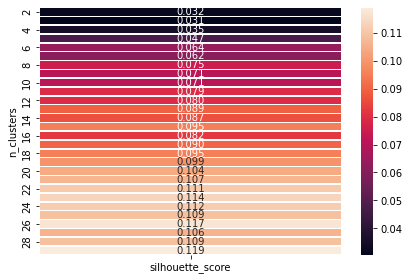

In [90]:
# Silhouette Score - 최적 k
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,30)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector_2nd) # 가장 높은 실루엣 계수와 매핑되는 k

In [128]:
# kmeans 군집 결과 확인
from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=29).fit_predict(vector_2nd)
cluster1_result['cluster2nd'] = result_2nd

cluster2_result = print_cluster_result( train=cluster1_result, 
                                       result=result_2nd, col_cluster="cluster2nd")

cluster num : 0
KT, 이문3 구역 신축 아파트에 AI 기반 청정환기 시스템 구축
KT, 이문3구역에 'AI 청정환기 시스템' 구축…"미세먼지 99.9% 줄여"
"미세먼지 막아라"…KT, 이문3구역에 AI 청정 환기 시스템 구축
이문3구역 새 아파트… `KT AI`로 청정 환기
KT, 이문3구역에 AI 청정환기 시스템 구축
KT, 이문3구역 신축 아파트에 'AI 청정환기 시스템' 구축
KT, 이문3구역 4300세대 AI 환기 시스템 구축
이문3구역, KT AI 청정환기 시스템 가동
KT, 동대문구 이문3구역 신축 예정 아파트에 'AI 청정환기 시스템' 구축
KT, 초미세먼지 대응...신축아파트에 AI청정환기시스템 구축
[통신가 소식] KT, 이문3구역에 AI 청정환기 시스템 구축·U+아이들나라, 오프라인 놀이교육으로 영역 확장
KT, 이문3구역 아파트에 AI 청정환기 시스템 구축

cluster num : 1
'개방직' 부산시 빅데이터통계과장에 김현선 前IBM 상무
심평원-데이터산업진흥원, 업무협약 "빅데이터 기반 혁신 창출"
주가 폭락에 증권거래세 34%↓…"이참에 폐지" 주장도 [강진규의 데이터너머]
[아!이뉴스] '국가데이터정책위' 출범 임박…블리자드가 쏘아 올린 '이모탈'
제1회 '빅데이터AI포럼' 개최…"빅데이터와 AI 통해 정책 제안"
[빅데이터MSI]30일 오전 주식시장 심리 4단계 '보통'
90兆 데이터처리 시장 샛별 '망고부스트' 130억 펀딩
바이어 찾아주는 AI…빅데이터 활용해 유망 거래처 3분 만에 뽑아줘
국립암센터, 인공지능·빅데이터 국제심포지엄 개최
셀렉트스타, 8억원 규모 'AI 데이터셋 지원사업' 시작
'빅데이터로 보는 지방선거' 3차 분석
가이온, 데이터바우처 공급 4년 연속 협약 체결
데이터산업시대 보건의료정보관리 역할·전략 모색
한국수산자원공단, 공공데이터 구축ㆍ개방
아이폰수리 '아이픽스 강남선릉점' 데이터복구 당일 서비스 진행
6·1 지방선거 개표방송서도 AI·빅데이터 활약 이어진다
대구시, 제4회 빅데이터 분석

In [132]:
# cluster2_result.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_cluster2_result.csv', index=False)
# cluster1_result.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_cluster1_result.csv', index=False)

# 4. keyword 추출

In [63]:
key_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')  #distilbert-base-nli-mean-tokens / paraphrase-multilingual-MiniLM-L12-v2

In [130]:
def keyword(data, col_cluster):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    result = []
    for i in range(len(data)):
        key_text = cluster1_result[cluster1_result[col_cluster]==i]['noun']
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,2), top_n=1)
        result.append(keyword[0][0])
    return result

def merge_keyword(data, col_cluster): #새 열로 추가.
    data_temp = data.copy()
    data_temp['keyword'] = keyword(data, col_cluster)
    return data_temp

keyword_result = merge_keyword(cluster2_result, col_cluster='cluster2nd')

keyword_df = keyword_result[['cluster_num', 'count', 'keyword']]
keyword_df.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
keyword_df.drop(index=[0], inplace=True)
keyword_df = keyword_df[keyword_df['count']>5]
lst = []
for i in keyword_df['keyword']:
  lst.append(i.upper())
keyword_df['keyword'] = lst
keyword_df


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,cluster_num,keyword,title
0,15,인공지능 업체들,AI 하드웨어·소프트웨어 대표 스타트업 손 잡았다
1,15,인공지능 업체들,[기고] AI 기본 이해하기
2,15,인공지능 업체들,"65세이상 안전 운전 돕는다... 日 혼다, 사고방지 AI 개발 나서"
3,15,인공지능 업체들,"일본 혼다, ‘운전자 몸상태’ AI로 감지해 사고 예방"
4,15,인공지능 업체들,"대졸자도, 비전공자도 AI 인재로…현장 통합 실습이 비결"
5,15,인공지능 업체들,"""AI가 운전자 인지능력 확인""…日 혼다, 2030년 상용화"
6,15,인공지능 업체들,9월 광주서 'AI TECH+' 전시회
7,15,인공지능 업체들,광주에서 국내 최대 AI 기술 전시회 연다
8,15,인공지능 업체들,"""요즘 건강 괜찮으세요?""…네이버 AI로 어르신 감정안부 챙긴다"
9,15,인공지능 업체들,윤동식 KT클라우드 대표 “2026년까지 매출 2조원 목표... AI·공공분야 공략”


In [145]:
keyword_df.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/keyword_result.csv', index=False)


# 5. 최종 데이터

In [146]:
temp_df = cluster1_result[['title', 'url', 'thumbnail', 'cluster2nd']]
final = keyword_df.merge(temp_df, left_on='cluster_num', right_on='cluster2nd').drop(columns=['cluster2nd', 'count'])
final_temp = final.iloc[:, :3] 
final_temp

,cluster_num,keyword,title
0,15,인공지능 업체들,AI 하드웨어·소프트웨어 대표 스타트업 손 잡았다
1,15,인공지능 업체들,[기고] AI 기본 이해하기
2,15,인공지능 업체들,"65세이상 안전 운전 돕는다... 日 혼다, 사고방지 AI 개발 나서"
3,15,인공지능 업체들,"일본 혼다, ‘운전자 몸상태’ AI로 감지해 사고 예방"
4,15,인공지능 업체들,"대졸자도, 비전공자도 AI 인재로…현장 통합 실습이 비결"
5,15,인공지능 업체들,"""AI가 운전자 인지능력 확인""…日 혼다, 2030년 상용화"
6,15,인공지능 업체들,9월 광주서 'AI TECH+' 전시회
7,15,인공지능 업체들,광주에서 국내 최대 AI 기술 전시회 연다
8,15,인공지능 업체들,"""요즘 건강 괜찮으세요?""…네이버 AI로 어르신 감정안부 챙긴다"
9,15,인공지능 업체들,윤동식 KT클라우드 대표 “2026년까지 매출 2조원 목표... AI·공공분야 공략”


In [147]:
temp_df.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/reports.csv', index=False)
final.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final.csv', index=False)